## Data and Model Creation

In [1]:
import torch
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import pandas as pd
from PIL import Image
import os
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

# Define Custom Dataset Class
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = self.img_labels.iloc[idx, 1]
        if not os.path.isfile(img_path):
            raise FileNotFoundError(f"File not found: {img_path}")
        image = Image.open(img_path).convert("RGB")
        top = self.img_labels.iloc[idx, 3]
        left = self.img_labels.iloc[idx, 4]
        height = self.img_labels.iloc[idx, 5]
        width = self.img_labels.iloc[idx, 6]
        bbox = torch.tensor([top, left, height, width], dtype=torch.float32)

        if self.transform:
            image = self.transform(image)

        return image, bbox

# Define Custom SafeColorJitter Class without hue adjustment
class SafeColorJitter(transforms.ColorJitter):
    def __init__(self, brightness=0, contrast=0, saturation=0):
        super().__init__(brightness=brightness, contrast=contrast, saturation=saturation, hue=0)

    def get_params(self, brightness, contrast, saturation, hue=(0, 0)):
        transform_list = []
        if brightness is not None:
            brightness_factor = torch.empty(1).uniform_(brightness[0], brightness[1]).item()
            transform_list.append(lambda img: transforms.functional.adjust_brightness(img, brightness_factor))
        if contrast is not None:
            contrast_factor = torch.empty(1).uniform_(contrast[0], contrast[1]).item()
            transform_list.append(lambda img: transforms.functional.adjust_contrast(img, contrast_factor))
        if saturation is not None:
            saturation_factor = torch.empty(1).uniform_(saturation[0], saturation[1]).item()
            transform_list.append(lambda img: transforms.functional.adjust_saturation(img, saturation_factor))

        return transform_list

    def forward(self, img):
        params = self.get_params(self.brightness, self.contrast, self.saturation)
        for param in params:
            img = param(img)
        return img

# Define Transformations with SafeColorJitter without hue adjustment
# transform = transforms.Compose([
#     transforms.Resize((256, 256)),
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomRotation(15),
#     SafeColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=(0.8, 1.2)),
#     transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.8, 1.2)),
#     transforms.RandomGrayscale(p=0.1),
#     transforms.ToTensor()
# ])

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    SafeColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=(0.8, 1.2)),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.8, 1.2)),
    transforms.RandomGrayscale(p=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])



# Create Dataset and DataLoader
dataset = CustomImageDataset(
    annotations_file='/Users/matt/Documents/Coding/Midjourney/MockCrop/data/mockupdetection_724.csv',
    transform=transform
)

batch_size = 2
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)

# # Define Improved Model with more complexity
# class ImprovedCNN(nn.Module):
#     def __init__(self):
#         super(ImprovedCNN, self).__init__()
#         self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
#         self.bn1 = nn.BatchNorm2d(32)
#         self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
#         self.bn2 = nn.BatchNorm2d(64)
#         self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
#         self.bn3 = nn.BatchNorm2d(128)
#         self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
#         self.fc1 = nn.Linear(128 * 32 * 32, 512)
#         self.dropout = nn.Dropout(0.5)
#         self.fc2 = nn.Linear(512, 256)
#         self.fc3 = nn.Linear(256, 4)

#     def forward(self, x):
#         x = self.pool(F.relu(self.bn1(self.conv1(x))))
#         x = self.pool(F.relu(self.bn2(self.conv2(x))))
#         x = self.pool(F.relu(self.bn3(self.conv3(x))))
#         x = x.view(-1, 128 * 32 * 32)
#         x = F.relu(self.fc1(x))
#         x = self.dropout(x)
#         x = F.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x

# model = ImprovedCNN()

# # Define Loss and Optimizer
# criterion = nn.SmoothL1Loss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.25)

# # Move Model to Device
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model.to(device)


# Define ResNet Model with modifications
class ResNet(nn.Module):
    def __init__(self, num_classes=4):
        super(ResNet, self).__init__()
        resnet50 = models.resnet50(pretrained=True)
        self.features = nn.Sequential(*list(resnet50.children())[:-1])
        self.classifier = nn.Linear(resnet50.fc.in_features, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

resnet_model = ResNet(num_classes=4)

# Define Loss and Optimizer for ResNet
criterion = nn.SmoothL1Loss()
optimizer = torch.optim.Adam(resnet_model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.25)

# Move Model to Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
resnet_model.to(device)

/Users/matt/Documents/Coding/Midjourney/MockCrop/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/matt/Documents/Coding/Midjourney/MockCrop/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 

## Training

In [3]:
# Training Loop with early stopping
num_epochs = 10
best_loss = float('inf')
early_stop_patience = 10
early_stop_counter = 0

for epoch in range(num_epochs):
    resnet_model.train()
    running_loss = 0.0
    for images, bboxes in train_loader:
        images, bboxes = images.to(device), bboxes.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = resnet_model(images)
        
        # Compute loss
        loss = criterion(outputs, bboxes)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    epoch_loss = running_loss / len(train_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')
    
    # Step the scheduler
    scheduler.step()

    # Early stopping
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        early_stop_counter = 0
    else:
        early_stop_counter += 1

    if early_stop_counter >= early_stop_patience:
        print("Early stopping triggered")
        break

print('Finished Training')

# # Save the Model Checkpoint
# model_save_path = '/Users/matt/Documents/Coding/Midjourney/MockCrop/models/model_BAD.pth'
# torch.save(model.state_dict(), model_save_path)
# print(f'Model saved to {model_save_path}')

# # Load the Model Checkpoint
# model_load_path = '/Users/matt/Documents/Coding/Midjourney/MockCrop/models/model_BAD.pth'
# model = ImprovedCNN()
# model.load_state_dict(torch.load(model_load_path))
# model.to(device)
# model.eval()
# print(f'Model loaded from {model_load_path}')


Epoch [1/10], Loss: 891.0802
Epoch [2/10], Loss: 875.1673
Epoch [3/10], Loss: 804.2573
Epoch [4/10], Loss: 773.5633
Epoch [5/10], Loss: 703.7292
Epoch [6/10], Loss: 640.6164
Epoch [7/10], Loss: 605.8837
Epoch [8/10], Loss: 570.5005
Epoch [9/10], Loss: 557.6649
Epoch [10/10], Loss: 547.6531
Finished Training


In [4]:
# Save the Model Checkpoint
model_save_path = '/Users/matt/Documents/Coding/Midjourney/MockCrop/models/model_728.pth'
torch.save(resnet_model.state_dict(), model_save_path)
print(f'Model saved to {model_save_path}')

# # Load the Model Checkpoint
# model_load_path = '/Users/matt/Documents/Coding/Midjourney/MockCrop/models/model_BAD.pth'
# model = ImprovedCNN()
# model.load_state_dict(torch.load(model_load_path))
# model.to(device)
# model.eval()
# print(f'Model loaded from {model_load_path}')

Model saved to /Users/matt/Documents/Coding/Midjourney/MockCrop/models/model_728.pth


## Validation

In [5]:
# Load Validation Image
new_image_path = '/Users/matt/Documents/Coding/Midjourney/MockCrop/images/validate/val1.png'  # Replace with the actual path to the new image

In [8]:
# Load the model
model_load_path = '/Users/matt/Documents/Coding/Midjourney/MockCrop/models/model_728.pth'
# model = ImprovedCNN()
model = ResNet()
model.load_state_dict(torch.load(model_load_path))
model.eval()
print(f"Model loaded from {model_load_path}")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

/Users/matt/Documents/Coding/Midjourney/MockCrop/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/matt/Documents/Coding/Midjourney/MockCrop/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Model loaded from /Users/matt/Documents/Coding/Midjourney/MockCrop/models/model_728.pth


ResNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 

Predicted Bounding Box: [np.float32(411.9812), np.float32(328.0091), np.float32(932.58276), np.float32(786.9106)]


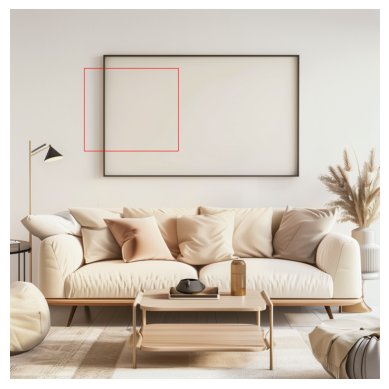

In [9]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
from PIL import Image
import torch
import torchvision.transforms as transforms

# # Define the ImprovedCNN model architecture
# class ImprovedCNN(nn.Module):
#     def __init__(self):
#         super(ImprovedCNN, self).__init__()
#         self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
#         self.bn1 = nn.BatchNorm2d(32)
#         self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
#         self.bn2 = nn.BatchNorm2d(64)
#         self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
#         self.bn3 = nn.BatchNorm2d(128)
#         self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
#         self.fc1 = nn.Linear(128 * 32 * 32, 512)
#         self.dropout = nn.Dropout(0.5)
#         self.fc2 = nn.Linear(512, 256)
#         self.fc3 = nn.Linear(256, 4)

#     def forward(self, x):
#         x = self.pool(F.relu(self.bn1(self.conv1(x))))
#         x = self.pool(F.relu(self.bn2(self.conv2(x))))
#         x = self.pool(F.relu(self.bn3(self.conv3(x))))
#         x = x.view(-1, 128 * 32 * 32)
#         x = F.relu(self.fc1(x))
#         x = self.dropout(x)
#         x = F.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x

# Define ResNet Model with modifications
class ResNet(nn.Module):
    def __init__(self, num_classes=4):
        super(ResNet, self).__init__()
        resnet50 = models.resnet50(pretrained=True)
        self.features = nn.Sequential(*list(resnet50.children())[:-1])
        self.classifier = nn.Linear(resnet50.fc.in_features, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


# # Load the model
# model_load_path = '/Users/matt/Documents/Coding/Midjourney/MockCrop/models/model5.pth'
# model = ImprovedCNN()
# model.load_state_dict(torch.load(model_load_path))
# model.eval()
# print(f"Model loaded from {model_load_path}")

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model.to(device)

def get_predicted_bbox(model, image_path):
    """
    Get the predicted bounding box from the model.
    
    Args:
    - model (torch.nn.Module): The trained model.
    - image_path (str): The path to the input image.
    
    Returns:
    - bbox (list): The predicted bounding box coordinates [x_min, y_min, x_max, y_max].
    """
    # Load the image and preprocess as required by your model
    image = Image.open(image_path).convert("RGB")
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor()
    ])
    input_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension and move to device
    
    # Get model prediction
    with torch.no_grad():
        output = model(input_tensor)
    
    # Assuming output is the bounding box [top, left, height, width]
    bbox = output[0].cpu().numpy()
    top, left, height, width = bbox
    x_min, y_min, x_max, y_max = left, top, left + width, top + height
    return [x_min, y_min, x_max, y_max]

def visualize_bbox(image, bbox, color=(255, 0, 0), thickness=2):
    """
    Visualize bounding box on the image.
    
    Args:
    - image (np.ndarray): The input image on which to draw the bounding box.
    - bbox (list): The bounding box coordinates [x_min, y_min, x_max, y_max].
    - color (tuple): The color of the bounding box. Default is green.
    - thickness (int): The thickness of the bounding box. Default is 2.
    
    Returns:
    - image (np.ndarray): The image with the bounding box drawn.
    """
    left, top, right, bottom = bbox
    start_point = (int(left), int(top))
    end_point = (int(right), int(bottom))
    
    image = cv2.rectangle(image, start_point, end_point, color, thickness)
    return image

def transform_image(image):
    """
    Transform the PIL image to a NumPy array.
    
    Args:
    - image (PIL.Image.Image): The input PIL image.
    
    Returns:
    - image (np.ndarray): The transformed NumPy array.
    """
    return np.array(image)

# Path to the new image
new_image_path = '/Users/matt/Documents/Coding/Midjourney/MockCrop/images/validate/test9.png'  # Replace with the actual path to the new image

# Get the predicted bounding box (green)
predicted_bbox = get_predicted_bbox(model, new_image_path)
print(f"Predicted Bounding Box: {predicted_bbox}")

# Visualize the predicted bounding box on the new image
new_image = Image.open(new_image_path).convert("RGB")
new_image_np = transform_image(new_image)  # Transform PIL image to NumPy array

# Draw the model's predicted bounding box (green)
visualized_image = visualize_bbox(new_image_np, predicted_bbox, color=(255, 0, 0), thickness=2)

# Display the image with the bounding box
plt.imshow(visualized_image)
plt.axis('off')  # Hide axes
plt.show()
